In [1]:
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp
# import hdf5storage # get code on https://pypi.python.org/pypi/hdf5storage/0.1.3
# import networkx as nx

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 写入mat
def WriteMatlab(data_np, VarName, FileName):
    matcontent = {}
    matcontent[VarName] = data_np
    hdf5storage.write(matcontent, filename=FileName, matlab_compatible=True)

In [4]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/BA_2000_6.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/BA_2000_6_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size doesn\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [5]:
# 参数设置

# 0. 公共参数
Monte_Carlo_loop = 100     # 蒙特卡洛模拟次数
time_steps = 100           # 总时间步数
N = network_scale_1[0]     # 网络节点数
w_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]    # S-I断边概率

# 1. SIS参数
bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

# 4. 其他参数
aplha = 0.4      # 信息上传率
iter_ = 0

infective_count_average_total = np.zeros([len(w_list), time_steps])
awareness_count_average_total = np.zeros([len(w_list), time_steps])

In [6]:
for w in w_list:
    
    time_start_w = time.time()
    
    random.seed(512)
    np.random.seed(512)

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])


    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])



    time_start = time.time()

    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
        network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    a_1 = 1 - (1 - lamda) ** Num_neighbor_listener    # 最终计算的传播率
                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a_1:
                        Nodes_UAU[loop, t+1, i] = 1
                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


            # ----------更改连边----------
            for i in range(N):
                if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                    
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                    susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 0))[0]                 # 易感节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                    # neighbor_susceptible = np.intersect1d(susceptible_nodes, neighbor_total)        # 取交集-易感邻居
                    neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 邻居里去除感染邻居-易感邻居

                    destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                    for infectNeighbor in neighbor_infective:
                        # 如果断边成功，则在当前时刻更改连接
                        if np.random.rand(1) <= w:
                            network_physical_t[t,i,infectNeighbor] = 0
                            network_physical_t[t,infectNeighbor,i] = 0

                            destination = random.choice(destinations)
                            destinations.remove(destination)

                            network_physical_t[t,i,destination] = 1
                            network_physical_t[t,destination,i] = 1

            # ----------SIS演化----------
            for i in range(N):

            # # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            # if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                if Nodes_SIS[loop, t, i] == 0:

                    neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                    # -----SIS感染过程1-----
                    # SIS感染率
                    v_1 = 1 - (1 - bata) ** Num_neighbor_infective
                    p = np.random.rand(1)
                    if p <= v_1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")

            # 将当前时间的接触网络复制到下一时刻
            network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

        # 保存本次蒙特卡洛循环产生的接触网络数据
        # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
        # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
        # name = 'loop_'+str(loop)
        # scio.savemat(addr, {name: network_physical_t})
        # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

        print("    loop {} - time has passed: {} ".format(loop, time.time()-time_start))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    awareness_count_average = np.mean(awareness_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

    infective_count_average_total[iter_, :] = infective_count_average/N
    awareness_count_average_total[iter_, :] = awareness_count_average/N
    iter_ += 1

    print("w = {} - time has passed: {} ".format(w, time.time()-time_start))

    loop 0 - time has passed: 55.250476360321045 
    loop 1 - time has passed: 107.1790132522583 
    loop 2 - time has passed: 166.50638270378113 
    loop 3 - time has passed: 224.86747431755066 
    loop 4 - time has passed: 276.30349612236023 
    loop 5 - time has passed: 325.79148602485657 
    loop 6 - time has passed: 375.8205609321594 
    loop 7 - time has passed: 427.1004295349121 
    loop 8 - time has passed: 474.8837308883667 
    loop 9 - time has passed: 523.0378930568695 
    loop 10 - time has passed: 569.9457523822784 
    loop 11 - time has passed: 615.3984980583191 
    loop 12 - time has passed: 661.9613282680511 
    loop 13 - time has passed: 708.2576220035553 
    loop 14 - time has passed: 754.1009495258331 
    loop 15 - time has passed: 798.9884097576141 
    loop 16 - time has passed: 843.6642963886261 
    loop 17 - time has passed: 888.0706281661987 
    loop 18 - time has passed: 933.3180809020996 
    loop 19 - time has passed: 978.6181564331055 
    l

    loop 63 - time has passed: 3093.108193397522 
    loop 64 - time has passed: 3174.539322376251 
    loop 65 - time has passed: 3221.3976595401764 
    loop 66 - time has passed: 3268.2514884471893 
    loop 67 - time has passed: 3314.057083129883 
    loop 68 - time has passed: 3396.210860013962 
    loop 69 - time has passed: 3441.9882640838623 
    loop 70 - time has passed: 3486.9654269218445 
    loop 71 - time has passed: 3532.5705111026764 
    loop 72 - time has passed: 3578.1644716262817 
    loop 73 - time has passed: 3624.4224467277527 
    loop 74 - time has passed: 3670.726294517517 
    loop 75 - time has passed: 3715.7413942813873 
    loop 76 - time has passed: 3762.460993051529 
    loop 77 - time has passed: 3807.177328824997 
    loop 78 - time has passed: 3852.335729122162 
    loop 79 - time has passed: 3899.111912250519 
    loop 80 - time has passed: 3945.292486667633 
    loop 81 - time has passed: 3991.261214733124 
    loop 82 - time has passed: 4037.301351

    loop 25 - time has passed: 1270.943204164505 
    loop 26 - time has passed: 1319.225662946701 
    loop 27 - time has passed: 1366.4806501865387 
    loop 28 - time has passed: 1414.7271127700806 
    loop 29 - time has passed: 1463.0797672271729 
    loop 30 - time has passed: 1511.9177417755127 
    loop 31 - time has passed: 1560.0817666053772 
    loop 32 - time has passed: 1607.9339520931244 
    loop 33 - time has passed: 1656.2035365104675 
    loop 34 - time has passed: 1704.266096830368 
    loop 35 - time has passed: 1751.8442471027374 
    loop 36 - time has passed: 1799.7342495918274 
    loop 37 - time has passed: 1848.235592365265 
    loop 38 - time has passed: 1896.6726446151733 
    loop 39 - time has passed: 1943.6419570446014 
    loop 40 - time has passed: 1991.2357730865479 
    loop 41 - time has passed: 2038.557692527771 
    loop 42 - time has passed: 2086.4255664348602 
    loop 43 - time has passed: 2134.6622858047485 
    loop 44 - time has passed: 2183.

    loop 88 - time has passed: 4560.557390451431 
    loop 89 - time has passed: 4610.799582719803 
    loop 90 - time has passed: 4659.582405328751 
    loop 91 - time has passed: 4709.572483062744 
    loop 92 - time has passed: 4758.781133174896 
    loop 93 - time has passed: 4807.884735107422 
    loop 94 - time has passed: 4859.069265127182 
    loop 95 - time has passed: 4908.757475852966 
    loop 96 - time has passed: 4958.965582609177 
    loop 97 - time has passed: 5040.699156522751 
    loop 98 - time has passed: 5091.605233430862 
    loop 99 - time has passed: 5141.435609340668 
w = 0.4 - time has passed: 5141.482486248016 
    loop 0 - time has passed: 50.81417417526245 
    loop 1 - time has passed: 102.8598301410675 
    loop 2 - time has passed: 155.98573327064514 
    loop 3 - time has passed: 208.15384101867676 
    loop 4 - time has passed: 260.12434363365173 
    loop 5 - time has passed: 311.2801032066345 
    loop 6 - time has passed: 393.70089077949524 
    loo

    loop 50 - time has passed: 3071.3173191547394 
    loop 51 - time has passed: 3141.7699208259583 
    loop 52 - time has passed: 3198.6305062770844 
    loop 53 - time has passed: 3254.02095079422 
    loop 54 - time has passed: 3307.514393568039 
    loop 55 - time has passed: 3361.3474583625793 
    loop 56 - time has passed: 3416.1437923908234 
    loop 57 - time has passed: 3471.347408056259 
    loop 58 - time has passed: 3508.129191160202 
    loop 59 - time has passed: 3563.999577522278 
    loop 60 - time has passed: 3619.9276502132416 
    loop 61 - time has passed: 3673.2538714408875 
    loop 62 - time has passed: 3732.691786289215 
    loop 63 - time has passed: 3820.784189939499 
    loop 64 - time has passed: 3876.6444432735443 
    loop 65 - time has passed: 3930.5504314899445 
    loop 66 - time has passed: 3984.039411306381 
    loop 67 - time has passed: 4040.378654718399 
    loop 68 - time has passed: 4093.3318634033203 
    loop 69 - time has passed: 4149.00329

    loop 12 - time has passed: 836.7313125133514 
    loop 13 - time has passed: 899.5456240177155 
    loop 14 - time has passed: 981.7804453372955 
    loop 15 - time has passed: 1043.9982917308807 
    loop 16 - time has passed: 1105.5676727294922 
    loop 17 - time has passed: 1166.1545345783234 
    loop 18 - time has passed: 1227.7713997364044 
    loop 19 - time has passed: 1288.8419370651245 
    loop 20 - time has passed: 1352.1218774318695 
    loop 21 - time has passed: 1411.5060527324677 
    loop 22 - time has passed: 1474.5906949043274 
    loop 23 - time has passed: 1536.7795114517212 
    loop 24 - time has passed: 1597.074542760849 
    loop 25 - time has passed: 1658.0750334262848 
    loop 26 - time has passed: 1721.5584254264832 
    loop 27 - time has passed: 1781.4747579097748 
    loop 28 - time has passed: 1841.5596449375153 
    loop 29 - time has passed: 1902.8710434436798 
    loop 30 - time has passed: 1963.9648973941803 
    loop 31 - time has passed: 2024

    loop 74 - time has passed: 5167.945039987564 
    loop 75 - time has passed: 5234.5255534648895 
    loop 76 - time has passed: 5301.08606672287 
    loop 77 - time has passed: 5368.978335142136 
    loop 78 - time has passed: 5435.633702039719 
    loop 79 - time has passed: 5502.46106171608 
    loop 80 - time has passed: 5568.1645629405975 
    loop 81 - time has passed: 5635.648819208145 
    loop 82 - time has passed: 5701.913921117783 
    loop 83 - time has passed: 5766.969943284988 
    loop 84 - time has passed: 5831.743570566177 
    loop 85 - time has passed: 5898.9926545619965 
    loop 86 - time has passed: 5963.43199634552 
    loop 87 - time has passed: 6042.634674549103 
    loop 88 - time has passed: 6111.833360910416 
    loop 89 - time has passed: 6178.148828744888 
    loop 90 - time has passed: 6243.997103691101 
    loop 91 - time has passed: 6310.773483991623 
    loop 92 - time has passed: 6376.195453166962 
    loop 93 - time has passed: 6442.195159673691 


In [7]:
# plt.plot(infective_count_average/N, color='blue', label='SIS')
# plt.plot(awareness_count_average/N, color='green', label='UAU')

In [8]:
addr = '../results/'
name1 = 'BA_BA_w_infective'
name2 = 'BA_BA_w_awareness'
scio.savemat(addr+name1+'.mat', {name1: infective_count_average_total})
scio.savemat(addr+name2+'.mat', {name2: awareness_count_average_total})

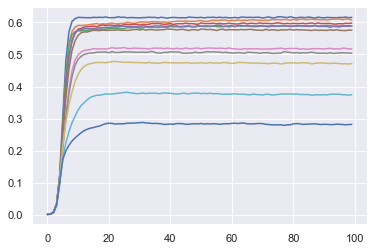

In [9]:
for w_ in range(len(w_list)):
    plt.plot(infective_count_average_total[w_,:], label=str(w_list[w_]))